In [1]:
%load_ext autoreload
%autoreload 2
%run ~/FKMC/notebooks/notebook_preamble.py
%matplotlib inline
np.seterr(under = 'ignore')
from time import time

Imported pathlib::Path, os, munch::Munch, pickle, logging, itertools::count, matplotlib::colors
Names are pyplot = plt, matplotlib = mpl, numpy = np


## Goals for this notebook May 2020 3


* park at U = 5 and compare the MCMC results to the infinte temp results
* check that at U = 5 there are still in gap states at lower temp.

In [2]:
import shutil

## multi T mutli U data
from FKMC.import_funcs import get_data_structured, get_data_funcmap, mean_over_MCMC, IPRandDOS
def load(i, structure_dims): 
    p = Path(f'/data/users/tch14/slurm_runs/{i}')
    return get_data_funcmap(p,
                functions = [IPRandDOS(E_bins = np.linspace(-20, 20, 2000 + 1)), mean_over_MCMC('Mf_moments')],
                structure_names = ('repeats','Ts'),
                structure_dims = structure_dims,
               )

logger = logging.getLogger('FKMC.import_funcs')
logger.setLevel(logging.INFO) 

#jobid = 154806; structure_dims = (30, None)#
#jobid = 155044; structure_dims = (5, None)#
#jobid = 155089; structure_dims = (10, None)
jobid = 155179; structure_dims = (10, None)

multiUT = load(jobid, structure_dims)
with open(f'/workspace/tch14/pickled_data/{jobid}_processed.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(multiUT, f, pickle.HIGHEST_PROTOCOL)
    print('Pickling Successful')

CRITICAL:FKMC.import_funcs:looking in /data/users/tch14/slurm_runs/155179
INFO:FKMC.import_funcs:job ids range from 0 to 109
INFO:FKMC.import_funcs:structure_names = ('repeats', 'Ts')
INFO:FKMC.import_funcs:structure_dims = (10, 11)
INFO:FKMC.import_funcs:Expected number of jobs 110
INFO:FKMC.import_funcs:Logger keys: ['Ns', 'Ts', 'parameters', 'MCMC_params', 'logs', 'desc'] 

INFO:FKMC.import_funcs:MCMC_params: {'state': '...', 'N_steps': 2000, 'N_burn_in': 1000, 'thin': 20, 'logger': <FKMC.montecarlo.Eigenspectrum_IPR_all object at 0x7fc828113630>, 'proposal': <function p_multi_site_uniform_reflect at 0x7fc8283aa1e0>, 'accept_function': <function perturbation_accept at 0x7fc8283aa510>, 'warnings': True} 

INFO:FKMC.import_funcs:MCMC Steps: 2000 with thinning = 20 for 100 recorded steps
INFO:FKMC.import_funcs:[(0, 'repeats', 10), (1, 'Ts', 11)]
INFO:FKMC.import_funcs:available observables = ['A', 'Fc', 'Ff', 'IPRs', 'Mf_moments', 'N_cumulants', 'N_sites', 'N_steps', 'Nc', 'Nf', 'accep

In [3]:
multiUT.hints.DOS

('Ns', 'repeats', 'Ts', 'energy index')

In [4]:
multiUT.Ns

array([ 35,  40,  50,  65,  80, 100, 125, 160, 200, 245])

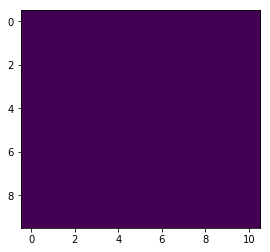

In [5]:
plt.imshow(np.any(np.isnan(multiUT.DOS), axis = (3))[:, 0, :])

In [6]:
from munch import munchify
from FKMC.general import smooth, spread
from scipy.stats import sem

#jobid = 154806; structure_dims = (30, None)#
#jobid = 155044; structure_dims = (5, None)#
#jobid = 155089; structure_dims = (10, None)

#this data has was preprocessed and saved in munich/Figures/Data_preparation_for_linear_T_plots.ipynb
#gatherered using get_data_funcmap so IPR is normalised by DOS
with open(f'/workspace/tch14/pickled_data/{jobid}_processed.pickle', 'rb') as file: 
    o = multiUT = munchify(pickle.load(file))
    
print(f"Keys available in long range data: {o.keys()}")

print("Hamiltionian params for the Long Range data:")
o.parameters.beta = "Variable"
print(", ".join(f"{k} = {v}" for k,v in o.parameters.items()))
print('\n')

print("Simulation params for the Long Range data:")
print(o.MCMC_params)

print('\nShape hint for o.IPR')
print(o.hints.DOS)
print(o.DOS.shape)
    
o.energy_histogram_bins = o.E_bins

#pluck out particular Ns and starting states
#Nmask = (o.Ns > 8)
#o.Ns = o.Ns[Nmask]
#print(o.Ns, Nmask)
#for name in ['DOS', 'dDOS', 'IPR', 'dIPR']:
#    o[name] = o[name][Nmask]
    #o[name] = o[name][:, :, [0,1,2]] #get particular starting states

axis = (1,) #mean out the repeat and starting states axes
print(f'Taking mean over axes {axis} which are {np.array(o.hints.DOS)[axis,]}')

#use the indepedant repeats to estimate the errors
o.DOS, o.dDOS = o.DOS.mean(axis = axis), sem(o.DOS, axis = 1)
o.IPR, o.dIPR = o.IPR.mean(axis = axis), sem(o.IPR, axis = 1)

#use binning over the mcmc steps to estimate the errors
#o.DOS, o.dDOS = np.nanmean(o.DOS, axis = axis), np.nanmean(o.dDOS, axis = axis)
#o.IPR, o.dIPR = np.nanmean(o.IPR, axis = axis), np.nanmean(o.dIPR, axis = axis)

print('\nShape of o.DOS after mean')
print("Should be ('Ns', 'Ts', 'energy index')")
print(o.DOS.shape)

#('Ns', 'Ts', 'energy index')

#smooth them
for i, N in zip(count(), o.Ns):
    scale = 0.5
    o.DOS[i] = smooth(o.DOS[i], scale)
    o.IPR[i] = smooth(o.IPR[i], scale)

    o.dDOS[i] = smooth(o.dDOS[i], scale)
    o.dIPR[i] = smooth(o.dIPR[i], scale)

Keys available in long range data: dict_keys(['E_bins', 'IPR', 'DOS', 'dIPR', 'dDOS', 'Mf_moments', 'sigma_Mf_moments', 'Ns', 'Ts', 'parameters', 'MCMC_params', 'desc', 'structure_names', 'structure_dims', 'hints', 'T'])
Hamiltionian params for the Long Range data:
t = 1, alpha = 1.25, mu = 0, beta = Variable, J = 5, U = 10, normalise = True, J_matrix = ...


Simulation params for the Long Range data:
Munch({'state': '...', 'N_steps': 2000, 'N_burn_in': 1000, 'thin': 20, 'logger': <FKMC.montecarlo.Eigenspectrum_IPR_all object at 0x7fc823d4a2e8>, 'proposal': <function p_multi_site_uniform_reflect at 0x7fc8283aa1e0>, 'accept_function': <function perturbation_accept at 0x7fc8283aa510>, 'warnings': True})

Shape hint for o.IPR
('Ns', 'repeats', 'Ts', 'energy index')
(10, 10, 11, 2000)
Taking mean over axes (1,) which are ['repeats']

Shape of o.DOS after mean
Should be ('Ns', 'Ts', 'energy index')
(10, 11, 2000)


# Discussion of the DOS and IPR processing

The data generated by both the montecarlo routine and the infinite temperature model consists of list of observations. Say that we generate a list of f-electron system configurations $f_{ij}$ where i runs over samples and j runs over the site index from 0 to N-1. Diagonalising the resulting hamiltonian we get observations of N different energies, call them $E_{ij}$ and we can also calcualate the IPR of each state, call the $IPR_{ij}$

To plot a histogram I need to put these observations into bins. I have create an evenly spaced list of energies across the spectrum $B_k$ that represent the bins such that an energy $e$ is in bin $k$ if $B_{k-1} < e < B_{k}$

Now there is more than one way to calculate the DOS and IPR:

## Option 1: Flatten everything to 1D and bin it all
sum_DOS_k = The number of occurences of $E_ij$ that fall into the kth bin.
sum_IPR_k = The sum of all the IPRs that correspond to a state with energy in the kth bin.

IPR_k = sum_IPR_k / sum_DOS_k unless sum_DOS_k = 0 in which case set it to 0 or NaN.
DOS_k = sum_DOS_k / system_size / bin_width

## Option 2: Treat the sample axis as (semi)independant observations of the DOS and IPR, take ratio then mean
For each observation i:
    sum_DOS_k = The number of occurences of $E_ij$ that fall into the kth bin.
    sum_IPR_k = The sum of all the IPRs that correspond to a state with energy in the kth bin.

    IPR_k = sum_IPR_k / sum_DOS_k
    DOS_k = sum_DOS_k / system_size / bin_width

Then take all thos IPRs and DOS observations and take means and variances. 

## Option 3: Treat the sample axis as (semi)independant observations of the DOS and IPR, mean then ratio
For each observation i:
    sum_DOS_k = The number of occurences of $E_ij$ that fall into the kth bin.
    sum_IPR_k = The sum of all the IPRs that correspond to a state with energy in the kth bin.

Now take means to get the unnormalised sum_IPR and sum_DOS then:
IPR = sum_IPR / sum_DOS
DOS = sum_DOS / system_size / bin_width

But to get variances, still need to calculate IPR ratios across the samples and take means as in option 2.

Observations: Options 1 and 3 give the correct scaling (or lack of) scaling for the IPR. Option 2 where the ratio is calculated for each sample and then those ratios are meaned together gives a scaling up of sqrt(N) for the IPRs.


In [7]:
from FKMC.general import interaction_matrix, solve_H_vectorised, shapes
from FKMC.general import index_histogram_array, sort_IPRs, normalise_IPR, smooth, get_nearby_index, spread
from time import time
from FKMC.general import scaling_dimension
from FKMC.stats import binned_error_estimate_multidim

def compute_IPR_and_DOS_histograms_1D(raw_eigenvals, raw_IPRs, E_bins, bootstrap_bins = 1):
    raw_eigenvals = raw_eigenvals.flatten()
    raw_IPRs = raw_IPRs.flatten()
    N, = raw_eigenvals.shape
    
    sum_DOS, _, indices = index_histogram_array(E_bins, raw_eigenvals)
    sum_IPR = sort_IPRs(indices, raw_IPRs, E_bins)
    sum_squared_IPR = sort_IPRs(indices, raw_IPRs**2, E_bins)
    
    #normalise the IPR by the number of observations, but set to NaN when there are none.
    _, IPR = normalise_IPR(sum_DOS, sum_IPR)
    _, IPR_squared = normalise_IPR(sum_DOS, sum_squared_IPR)
    
    #assume poissonian errors because it's just counting
    #error of a poisson is sqrt(N)
    #error in the mean of a poisson in 1 / sqrt(N)
    dsum_DOS = 1 / np.sqrt(sum_DOS) 
    #use standard error in the mean = sqrt(<x**2> - <x>**2) / sqrt(N)
    dIPR = np.sqrt(IPR_squared - IPR**2) / np.sqrt(N) 
    
    #normalise by bin_width so that different binning doesn't affect the value
    #normalise by the system size so that plotting different ones together works
    #the outcome is that sum(DOS * bin_width) == 1
    bin_width = E_bins[1] - E_bins[0]
    DOS = sum_DOS / (N * bin_width)
    dDOS = dsum_DOS / (N * bin_width)
    
    return DOS, dDOS, IPR, dIPR
    

def compute_IPR_and_DOS_histograms_ratio_then_mean(raw_eigenvals, raw_IPRs, E_bins, bootstrap_bins = 1):
    #create sums of observations, for DOS just count the number of states seen in each bin 
    M, N = raw_eigenvals.shape
    sum_DOS, _, indices = index_histogram_array(E_bins, raw_eigenvals)
    sum_IPR = sort_IPRs(indices, raw_IPRs, E_bins)
    
    #normalise the IPR by the number of observations, but set to NaN when there are none.
    _, IPR = normalise_IPR(sum_DOS, sum_IPR)
    
    #normalise by bin_width so that different binning doesn't affect the value
    #normalise by the system size so that plotting different ones together works
    #the outcome is that sum(DOS * bin_width) == 1
    bin_width = E_bins[1] - E_bins[0]
    DOS = sum_DOS / (N * bin_width)
    
    #the below method splits into bins to deal with autocorrelation, set N_bins = 1 to ignore autocorellation
    dDOS = binned_error_estimate_multidim(DOS, N_bins = bootstrap_bins, axis = 0)
    dIPR = binned_error_estimate_multidim(IPR, N_bins = bootstrap_bins, axis = 0)
    
    DOS = DOS.mean(axis = 0)
    IPR = IPR.mean(axis = 0)

    return DOS, dDOS, IPR, dIPR

def compute_IPR_and_DOS_histograms(raw_eigenvals, raw_IPRs, E_bins, bootstrap_bins = 1):
    '''
    Start with observations of states with energy raw_eigenvals[i,j] and inverse participation ratio raw_IPRs[i,j]
    They have shape M,N where M is the number of observed systems and N is the system size (hence number of states observed)
    i labels system conigurations and j labels individual states
    E_bins are the bins to sort into
    bootstrap_bins is how many bins to use to estimate the error when autocorrelation is present.

    #In the MCMC routine itself
    0) Calculate the IPRs from the eigenvectors, this looks like
       IPRs = ((evecs * np.conj(evecs))**2).sum(axis = 0)
       making sure to sum over the correct axis!

    #In this function
    1) transform from lists of energies and IPR observations to sum of:
        sum_DOS_ik: the number of observations of energy in each bin k at each sys config i
        sum_IPR_ik: the sum of IPRs for states in energy bin k at each sys config i
        
    2) estimate errors:
        DOS by simply binning
        IPR by estimating IPR = sum_IPR / sum_DOS at each sys config and binning
        
    3) take means of sum_DOS and sum_IPR

    4) calculate 
        IPR = <sum_IPR> / <sum_DOS>
        DOS = sum_DOS / energy_bin_width / system_size
    
    5) smooth out the spikieness of the resulting histogram using\
    
    Crucially the mean is taken before the ratio, doing it the other way doesn't seem to work.
    '''
    #take lists of IPR and eigenvalues and bin them into histograms
    sum_DOS, _, sorting_indices = index_histogram_array(E_bins, raw_eigenvals)
    sum_IPR = sort_IPRs(sorting_indices, raw_IPRs, E_bins)

    #the below method splits into bins to deal with autocorrelation, set N_bins = 1 to ignore autocorellation
    sum_dDOS = binned_error_estimate_multidim(sum_DOS, N_bins = bootstrap_bins, axis = 0)
    
    #NB you can't caculate the error in sum_IPR because that is highly correlated with how many states appear in a bin!!!
    _, non_meaned_IPR_ratios = normalise_IPR(sum_DOS, sum_IPR)
    dIPR = binned_error_estimate_multidim(non_meaned_IPR_ratios, N_bins = bootstrap_bins, axis = 0)
    
    #now take the means and then take the ratio again!
    sum_DOS = sum_DOS.mean(axis = 0)
    sum_IPR = sum_IPR.mean(axis = 0)
    
    #divide <IPR> by <DOS> without incurring divide by errors where DOS = 0, set IPR = 0 there too
    _, IPR = normalise_IPR(sum_DOS, sum_IPR)
    
    M, N = raw_eigenvals.shape
    bin_width = E_bins[1] - E_bins[0]
    a = bin_width * N
    DOS, dDOS = sum_DOS / a, sum_dDOS / a
    
    #shapes(DOS=DOS, dDOS=dDOS, IPR=IPR, dIPR=dIPR)
    return DOS, dDOS, IPR, dIPR
    
o = Munch()
o.energy_histogram_bins = np.linspace(-5, 5, 10)
N = 200
M = 8 # Number of Disorder_realisations
states = np.random.choice([1,0], size = (M,N)) #take 50-50 uncorrelated coin flips to simulate infinite temp limit.
params = Munch(mu=0.0, beta = np.nan, U = 10, t = 1, N = N, alpha = 1.25, J = 1)
params.J_matrix = interaction_matrix(**params)

Ff, Fc, raw_eigenvals, raw_eigenvecs = solve_H_vectorised(states, **params)

#calculate the IPR measure
raw_IPRs = ((raw_eigenvecs * np.conj(raw_eigenvecs))**2).sum(axis = -2)

DOS, dDOS, IPR, dIPR = compute_IPR_and_DOS_histograms(raw_eigenvals, raw_IPRs, o.energy_histogram_bins)
bw = o.energy_histogram_bins[1] - o.energy_histogram_bins[0]
np.sum(DOS * bw)

1.0

In [8]:
cmap=plt.get_cmap('plasma')
x = np.linspace(0,1, 10)
cmap(x)

array([[0.050383, 0.029803, 0.527975, 1.      ],
       [0.274191, 0.012109, 0.622722, 1.      ],
       [0.447714, 0.00208 , 0.66024 , 1.      ],
       [0.610667, 0.090204, 0.619951, 1.      ],
       [0.740143, 0.213864, 0.524216, 1.      ],
       [0.846788, 0.342551, 0.420579, 1.      ],
       [0.928329, 0.472975, 0.326067, 1.      ],
       [0.983041, 0.624131, 0.227937, 1.      ],
       [0.991209, 0.790537, 0.149377, 1.      ],
       [0.940015, 0.975158, 0.131326, 1.      ]])

Computing the infT limit
U = 10 done in 1s
Done


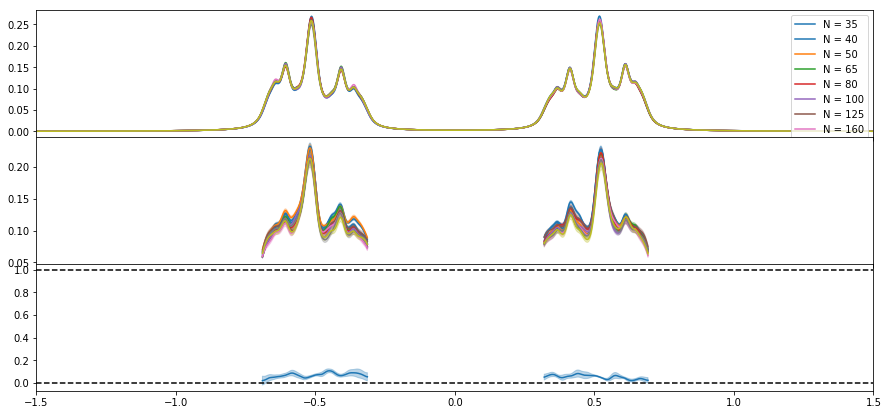

In [9]:
from FKMC.general import scaling_dimension

def plot_scaling_dimension(axes, o, T_i, spread_IPR = False, cutoffs = [0,], DOS_cutoff = 0.001):
    #print(" ".join(f'{k}={v}' for k,v in o.parameters.items() if k != 'J_matrix'))
    cmap=plt.get_cmap('tab10')
    colors = cmap(np.linspace(0,0.8,len(o.Ns)))
    #colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    Eidx = o.DOS[-1, T_i] < DOS_cutoff #region of insufficient data
    Erange = o.energy_histogram_bins[1:][~Eidx] / o.parameters.U
    Emin, Emax = np.min(Erange), np.max(Erange)
    
    for i,N in zip(count(), o.Ns):
        IPR = o.IPR[i, T_i].copy()
        IPR[Eidx] = np.NaN
        #compute the bounds of the IPR that gets plotted
        bw = o.energy_histogram_bins[1] - o.energy_histogram_bins[0]
        assert(abs(o.DOS[i, T_i].sum() * bw - 1) < 0.01)
        #print(f'sum = {o.DOS[i, T_i].sum() * bw}')
        
        axes[0].plot(o.energy_histogram_bins[1:] / o.parameters.U, o.DOS[i, T_i], label = f'N = {N}', color = colors[i])
        if spread_IPR:
            spread(axes[1], o.energy_histogram_bins[1:] / o.parameters.U, IPR, o.dIPR[i, T_i], color = colors[i])
        else:    
            axes[1].plot(o.energy_histogram_bins[1:] / o.parameters.U, IPR, color = colors[i])

        axes[0].set(xlim = (-1.5, 1.5))

    
    try:
        for cutoff in cutoffs:
            idx = (o.Ns >= cutoff)
            m, c, dm, dc = scaling_dimension(o.Ns[idx], o.IPR[idx, T_i], o.dIPR[idx, T_i], use_true_errors = True)
            m[Eidx] = np.NaN
            spread(axes[2], o.energy_histogram_bins[1:] / o.parameters.U, -m, dm, label = f'{cutoff} <= N < {max(o.Ns)}')

    except scipy.linalg.LinAlgError:
        pass


    xlim = axes[2].get_xlim()
    axes[2].hlines([0,1], xmin = xlim[0], xmax = xlim[1], linestyles = 'dashed')

    

def solve(states, params, energy_histogram_bins, scale = 0.5):
    params.J_matrix = interaction_matrix(**params)
    N = states.shape[-1]

    #NB the states argument should have only 1s and 0s
    #Fc is infinite at infinite temperature
    Ff, Fc, raw_eigenvals, raw_eigenvecs = solve_H_vectorised(states, **params)

    #calculate the IPR measure
    raw_IPRs = ((raw_eigenvecs * np.conj(raw_eigenvecs))**2).sum(axis = -2)
    
    DOS, dDOS, IPR, dIPR = compute_IPR_and_DOS_histograms(raw_eigenvals, raw_IPRs, energy_histogram_bins)

    bw = energy_histogram_bins[1] - energy_histogram_bins[0]
    #assert(abs(np.sum(DOS * bw) - 1) < 0.01)
    
    #smooth out the spikey values and normalise DOS by system size
    DOS = smooth(DOS, scale = scale, axis = -1)
    dDOS = smooth(dDOS, scale = scale, axis = -1)
    
    IPR = smooth(IPR, scale = scale, axis = -1)
    dIPR = smooth(dIPR, scale = scale, axis = -1)
    
    #assert(abs(np.sum(DOS * bw) - 1) < 0.01)
    
    #take a threshold on DOS
    #insufficient_data = (DOS < 1)
    
    #mask out IPR where the DOS is too low
    #IPR = np.ma.masked_where(insufficient_data, IPR)
    #dIPR = np.ma.masked_where(insufficient_data, dIPR)
    
    return DOS, IPR, dDOS, dIPR

print(f'Computing the infT limit')

def infinite_T(U, Ns, N_eigenstates = 1e5):
    t = time()
    o = Munch()
    o.N_eigenstates = int(N_eigenstates) # do states / N disorder realisations
    o.Ns = Ns# system sizes
    o.Ts = np.array([np.infty,])
    o.t = 1
    o.U = U
    o.J = 500
    o.spread_IPR = False

    o.energy_histogram_bins = multiUT.E_bins
    shape = (4, len(o.Ns), 1, len(o.energy_histogram_bins)-1)
    o.DOS, o.IPR, o.dDOS, o.dIPR = np.nan * np.zeros(shape = shape)

    for i,N in zip(count(), o.Ns):
        M = o.N_eigenstates // N + 1 # Number of Disorder_realisations
        states = np.random.choice([1,0], size = (M,N)) #take 50-50 uncorrelated coin flips to simulate infinite temp limit.
        o.parameters = Munch(mu=0.0, beta = np.nan, U = o.U, t = o.t, N = N, alpha = 1.25, J = o.J)
        o.DOS[i], o.IPR[i], o.dDOS[i], o.dIPR[i] = solve(states, o.parameters, scale = 1, energy_histogram_bins = o.energy_histogram_bins)

    o.hints = Munch()
    for name in ['DOS', 'IPR', 'dIPR', 'dDOS']: o.hints[name] = ('Ns', 'Ts', 'energy')
    print(f'U = {U} done in {time() - t:.0f}s')
    return o
    
Ns = np.array([ 35,  40,  50,  65,  80, 100, 125, 160, 200, 245])
infiniteT_os = infinite_T(U = 10, Ns=Ns, N_eigenstates = 1e4)

f, axes = plt.subplots(3,1, figsize = (15,7), 
                       sharex = 'col', sharey = 'row',
                      gridspec_kw = dict(wspace = 0, hspace = 0),
                      )
plot_scaling_dimension(axes, infiniteT_os, T_i = 0, cutoffs = [30], spread_IPR = True, DOS_cutoff = 0.05)
axes[0].legend()

print('Done')

/home/tch14/conda-envs/intelpython3.5/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/tch14/conda-envs/intelpython3.5/lib/python3.6/site-packages/numpy/core/_methods.py:130: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


U = 10 done in 0s
Done


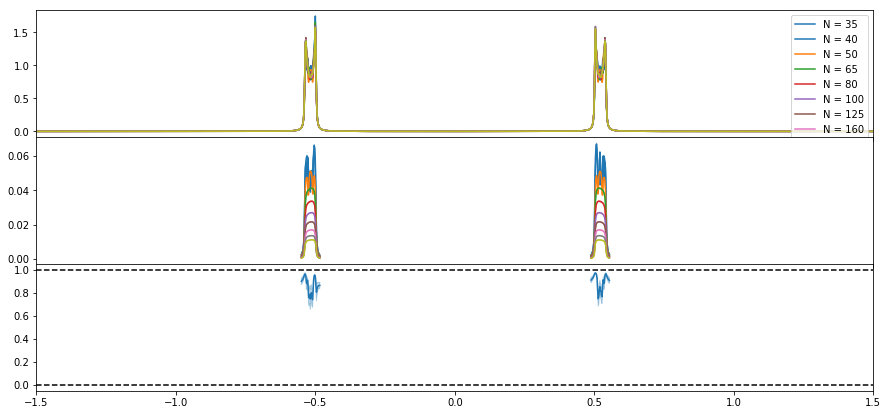

In [10]:
def zero_T(U, Ns):
    t = time()
    o = Munch()
    o.Ns = Ns# system sizes
    o.Ts = np.array([np.infty,])
    o.t = 1
    o.U = U
    o.J = 500
    o.spread_IPR = False

    o.energy_histogram_bins = multiUT.E_bins
    shape = (4, len(o.Ns), 1, len(o.energy_histogram_bins)-1)
    o.DOS, o.IPR, o.dDOS, o.dIPR = np.nan * np.zeros(shape = shape)

    for i,N in zip(count(), o.Ns):
        M = 1 # Number of disorder realisations
        states = np.ones(M)[:, None] * (np.arange(N) % 2)[None, :]
        o.parameters = Munch(mu=0.0, beta = np.nan, U = o.U, t = o.t, N = N, alpha = 1.25, J = o.J)
        o.DOS[i], o.IPR[i], o.dDOS[i], o.dIPR[i] = solve(states, o.parameters, scale = 0.1, energy_histogram_bins = o.energy_histogram_bins)
        o.dDOS[i] = o.DOS[i] * 0.01
        o.dIPR[i] = o.IPR[i] * 0.01
        
    o.hints = Munch()
    for name in ['DOS', 'IPR', 'dIPR', 'dDOS']: o.hints[name] = ('Ns', 'Ts', 'energy')
    print(f'U = {U} done in {time() - t:.0f}s')
    return o
    
Ns = np.array([ 35,  40,  50,  65,  80, 100, 125, 160, 200, 245])
zeroT_os = zero_T(U = 10, Ns=Ns)

f, axes = plt.subplots(3,1, figsize = (15,7), 
                       sharex = 'col', sharey = 'row',
                      gridspec_kw = dict(wspace = 0, hspace = 0),
                      )
plot_scaling_dimension(axes, zeroT_os, T_i = 0, cutoffs = [30], spread_IPR = True, DOS_cutoff = 0.05)
axes[0].legend()

print('Done')

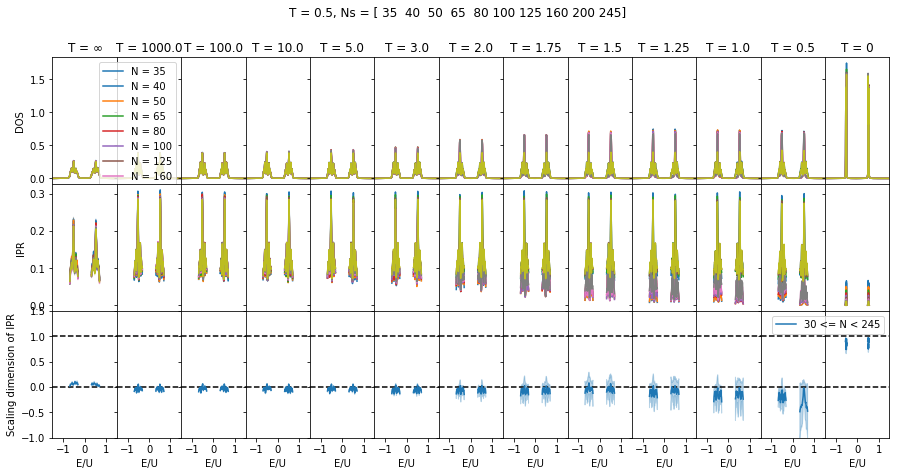

In [11]:
f, axes = plt.subplots(3,len(multiUT.Ts) + 2, figsize = (15,7), 
                       sharex = 'col', sharey = 'row',
                      gridspec_kw = dict(wspace = 0, hspace = 0),
                      )



axes[2,0].set(ylabel = 'Scaling dimension of IPR', ylim = (0,1))
axes[0,0].set(ylabel = 'DOS')    
axes[1,0].set(ylabel = 'IPR')

for a in axes[2, :]: a.set(xlabel = 'E/U')
    

axes.T[0,0].set(title = f'T = $\infty$')
plot_scaling_dimension(axes.T[0], infiniteT_os, T_i = 0, cutoffs = [30], spread_IPR = True, DOS_cutoff = 0.05)

for i, T in zip(count(), multiUT.Ts):
    axes.T[i+1,0].set(title = f'T = {T}')
    plot_scaling_dimension(axes.T[i+1], multiUT, T_i = i, cutoffs = [30], spread_IPR = False, DOS_cutoff = 0.05)
    
axes.T[-1,0].set(title = f'T = 0')
plot_scaling_dimension(axes.T[-1], zeroT_os, T_i = 0, cutoffs = [30], spread_IPR = True, DOS_cutoff = 0.05)

    
#for a in axes[2, :]: a.set(xlim = (-5,5))
#axes[1, 0].set(ylim = (0,0.03))
axes[2, 0].set(ylim = (-1,1.5))
axes[0,1].legend();
f.suptitle(f'T = {T}, Ns = {multiUT.Ns}')
axes[2,-1].legend();

In [12]:
multiUT.hints.Mf_moments

('Ns', 'repeats', 'Ts', 'nth moment')

NameError: name 'T_i' is not defined

['35 : 0.03', '40 : 0.03', '50 : 0.02', '65 : 0.02', '80 : 0.01', '100 : 0.01', '125 : 0.01', '160 : 0.01', '200 : 0.00', '245 : 0.00']


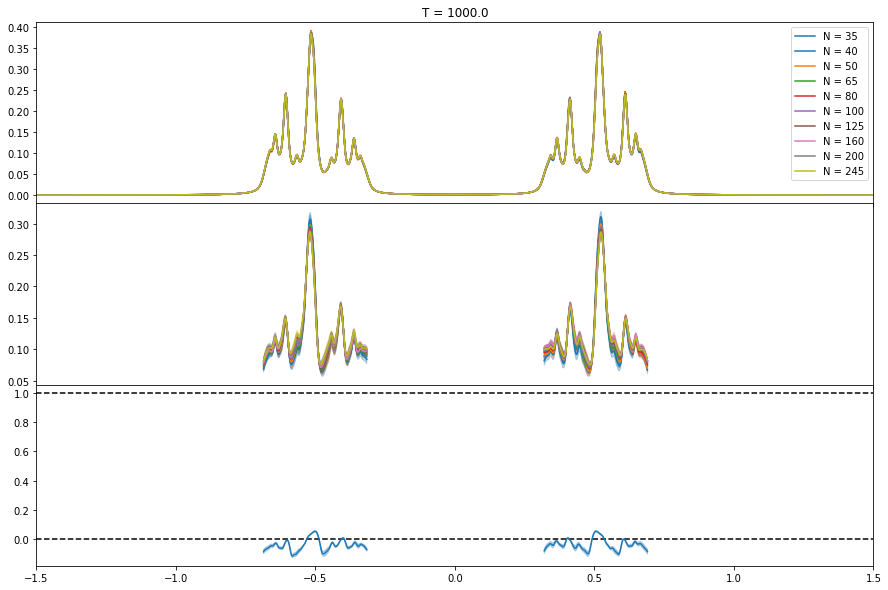

In [15]:
def indiv_plot(T_i):
    f, axes = plt.subplots(3,1, figsize = (15,10), 
                           sharex = 'col', sharey = 'row',
                          gridspec_kw = dict(wspace = 0, hspace = 0),
                          )

    T = multiUT.Ts[T_i]

    axes[0].set(title = f'T = {T}')

    plot_scaling_dimension(axes, multiUT, T_i = T_i, cutoffs = [30], spread_IPR = True, DOS_cutoff = 0.05)
    axes[0].legend()
    
    print([f'{N} : {Mf:.2f}' for N, Mf in zip(multiUT.Ns, multiUT.Mf_moments[:, :, T_i, 2].mean(axis = -1))])

indiv_plot(0)

['35 : 0.03', '40 : 0.10', '50 : 0.09', '65 : 0.02', '80 : 0.06', '100 : 0.04', '125 : 0.01', '160 : 0.03', '200 : 0.02', '245 : 0.00']


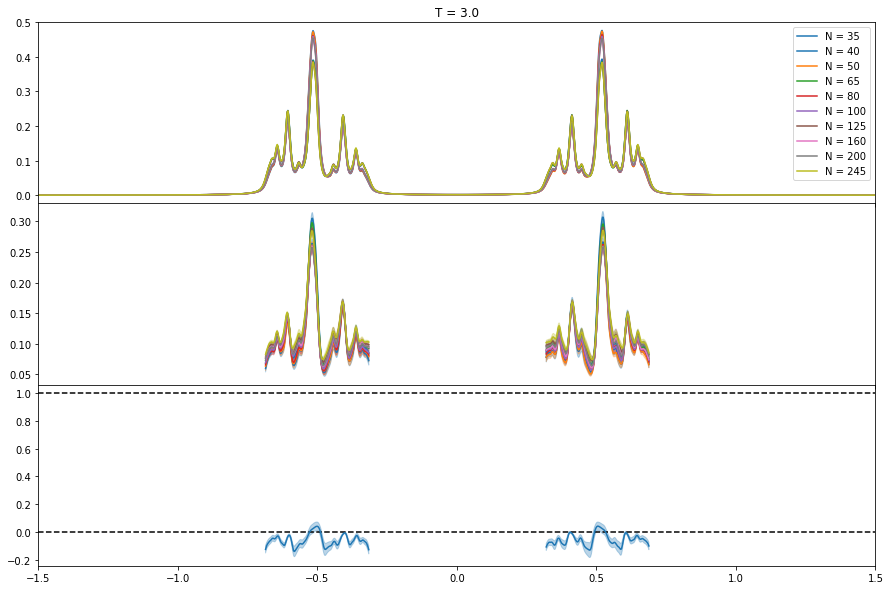

In [16]:
indiv_plot(4)

['35 : 0.03', '40 : 0.39', '50 : 0.39', '65 : 0.02', '80 : 0.37', '100 : 0.36', '125 : 0.01', '160 : 0.35', '200 : 0.37', '245 : 0.00']


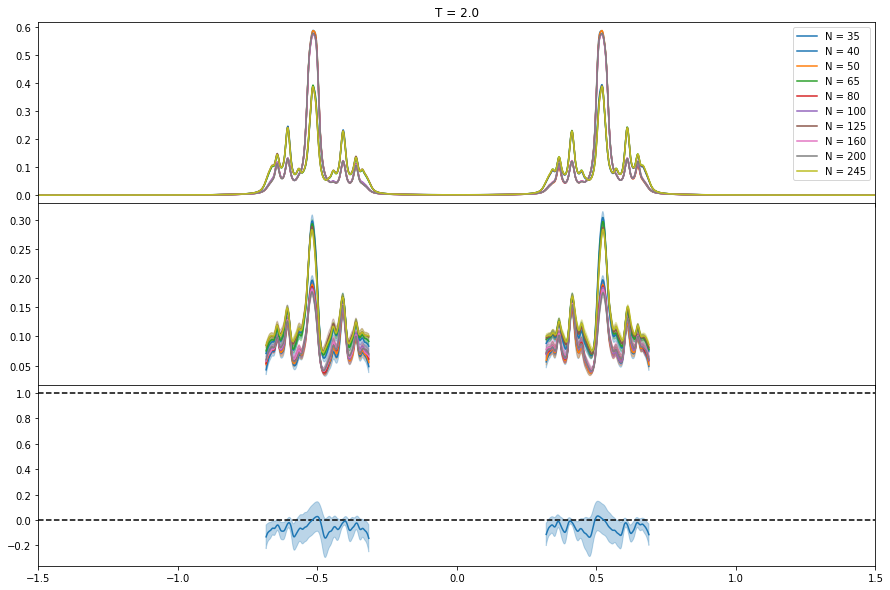

In [17]:
indiv_plot(5)

['35 : 0.03', '40 : 0.63', '50 : 0.65', '65 : 0.02', '80 : 0.65', '100 : 0.65', '125 : 0.01', '160 : 0.60', '200 : 0.65', '245 : 0.00']


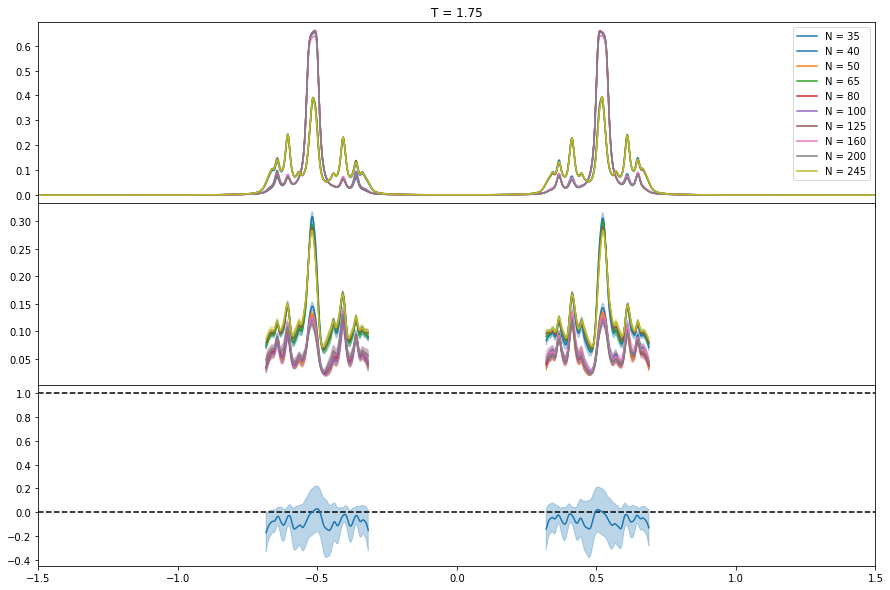

In [18]:
indiv_plot(6)

['35 : 0.03', '40 : 0.79', '50 : 0.83', '65 : 0.02', '80 : 0.75', '100 : 0.77', '125 : 0.01', '160 : 0.75', '200 : 0.67', '245 : 0.00']


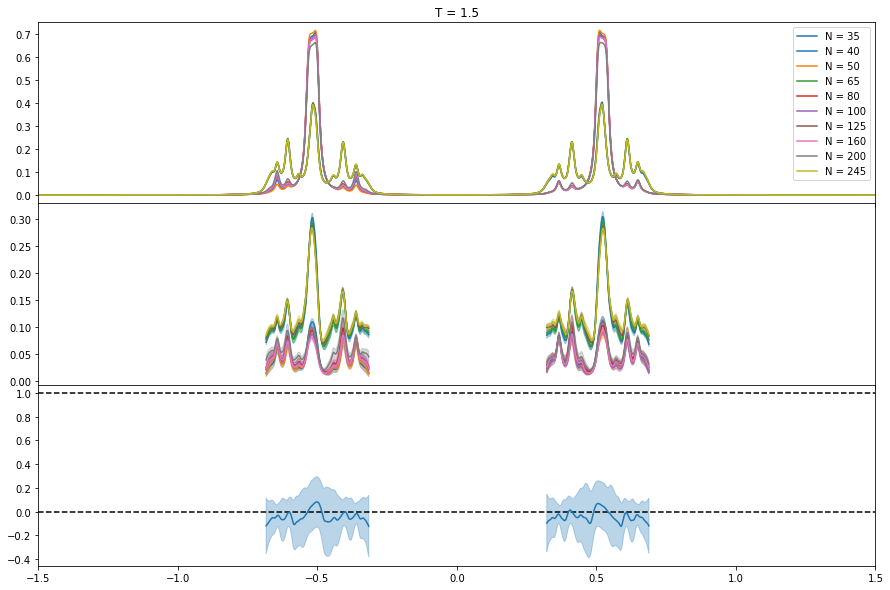

In [19]:
indiv_plot(7)

['35 : 0.03', '40 : 0.91', '50 : 0.87', '65 : 0.02', '80 : 0.82', '100 : 0.83', '125 : 0.01', '160 : 0.72', '200 : 0.71', '245 : 0.00']


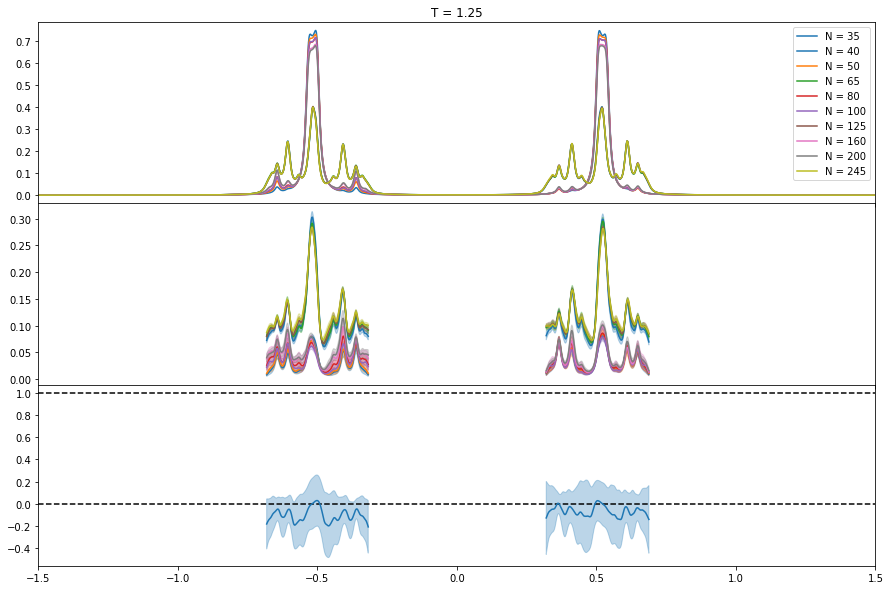

In [20]:
indiv_plot(8)

In [33]:
M = 10000
N = 1
true = 10

DOS = np.random.poisson(lam = N, size = M)
IPRs = [np.random.normal(loc = true, scale = 5, size = N) for N in DOS]

IPR_sums = np.array([np.sum(I) for I in IPRs])

mean_then_ratio = np.mean(IPR_sums) / np.mean(DOS)
ratio_then_mean = np.nanmean(IPR_sums / DOS)
true = 10

true, mean_then_ratio, ratio_then_mean

/home/tch14/conda-envs/intelpython3.5/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/home/tch14/conda-envs/intelpython3.5/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


(10, 9.928876161659355, 9.926846913317563)